In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
import importlib
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MLP, SetStyle, HistRoutine, net, PET, omnifold
from of_transformer import block, embed, input_distributed, net_utils, of_transformer, pair_embed, sequence_trimmer 
import test_omnifold
import PET

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="6" # GPU Server Available: 0,1,2,3,4,5,6,7
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="6"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

2025-11-03 10:03:11.433536: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-03 10:03:11.450767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762160591.468295 3651091 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762160591.473711 3651091 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762160591.489423 3651091 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
TUnfold_incl_path = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/unfolding_SR_Bulk_Final_l_4j_incl_TUnfoldStandalone_OptionA_data_nonClosureAlternative.root'
TUnfold_incl_file = uproot.open(TUnfold_incl_path)

pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
herwig_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_singletop_herwig_DR.pkl')

In [4]:
herwig_df

,run,event,eventWeight,ptl1,truth_ptl1,etal1,truth_etal1,phil1,truth_phil1,ptb1,...,truth_mj4,mj5,truth_mj5,mj6,truth_mj6,met,truth_met,metphi,truth_metphi,pass_matched
0,357409,22508018,0.169604,81.982521,84.499298,-2.388170,-2.387469,-2.485019,-2.483407,95.355629,...,0.00000,0.0,0.0,0.0,0.0,46.444607,38.480560,1.921275,2.259534,1
1,350880,22509111,0.174083,74.778412,74.519630,0.740382,0.740931,-0.406289,-0.406354,100.180794,...,0.00000,0.0,0.0,0.0,0.0,91.861198,75.036751,-0.843975,-1.118763,1
2,350531,22508867,0.167756,122.247360,121.482124,-0.186685,-0.187343,-0.720186,-0.720140,182.872467,...,5.80008,0.0,0.0,0.0,0.0,221.190186,206.596970,-1.270177,-1.151998,1
3,352394,22508341,0.096564,36.271080,36.235218,1.136148,1.136315,-1.632233,-1.631952,72.792068,...,0.00000,0.0,0.0,0.0,0.0,123.313614,70.481453,0.218302,0.450134,1
4,364098,22508882,0.152495,98.434067,101.572662,2.427591,2.428012,0.874990,0.874992,133.095703,...,0.00000,0.0,0.0,0.0,0.0,30.532061,9.217309,-2.734150,2.997609,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328978,349693,37435212,0.141358,0.000000,80.803581,0.000000,-0.446216,0.000000,-2.178269,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.000000,16.233683,0.000000,2.460174,2
2328979,355563,37434876,0.141358,0.000000,62.045506,0.000000,-0.114105,0.000000,-0.832910,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.000000,101.102814,0.000000,-1.732641,2
2328980,360129,37435182,0.141358,0.000000,32.287067,0.000000,1.695242,0.000000,-1.874062,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.000000,82.467316,0.000000,-0.695671,2
2328981,352056,37435028,0.141358,0.000000,54.756611,0.000000,-1.584736,0.000000,-1.205661,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.000000,65.964790,0.000000,-0.382474,2


In [5]:
def MC_data_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    truth_pts  = [df[f'truth_pt{p}']   for p in particle_names]
    truth_etas = [df[f'truth_eta{p}']  for p in particle_names]
    truth_phis = [df[f'truth_phi{p}']  for p in particle_names]
    
    truth_masses = [np.zeros_like(df['truth_ptl1'])] + \
                   [df[f'truth_mb{i}'] for i in range(1, 5)] + \
                   [df[f'truth_mj{i}'] for i in range(1, 7)]

    truth_features = np.stack([truth_pts, truth_etas, truth_phis, truth_masses], axis=-1)
    truth_features = truth_features.transpose(1, 0, 2)

    # Neutrino (truth): use 'truth_met' and 'truth_met_phi'
    truth_met_pt = df['truth_met']
    truth_met_phi = df['truth_metphi']
    zeros_truth = np.zeros_like(truth_met_pt)
    neutrino_truth = np.stack([truth_met_pt, zeros_truth, truth_met_phi, zeros_truth], axis=-1)

    truth_features = np.concatenate([truth_features, neutrino_truth[:, None, :]], axis=1)
    
    return reco_features, truth_features

In [9]:
pythia_reco, pythia_truth = MC_data_shaper(pythia_df)
herwig_reco, herwig_truth = MC_data_shaper(herwig_df)

pythia_weights = pythia_df['eventWeight'].to_numpy()
herwig_weights = herwig_df['eventWeight'].to_numpy()

pythia_pass_reco = pythia_df['pass_reco'].to_numpy()
pythia_pass_gen = pythia_df['pass_particle'].to_numpy()

herwig_pass_reco = herwig_df['pass_reco'].to_numpy()
herwig_pass_gen = herwig_df['pass_particle'].to_numpy()

In [11]:
all_indices_pythia = np.arange(len(pythia_reco))
np.random.seed(42)  # reproducibility
np.random.shuffle(all_indices_pythia)

# First random sample
random_indices_pythia_1 = all_indices_pythia[:1_000_000]
# Second, independent (non-overlapping) sample
random_indices_pythia_2 = all_indices_pythia[1_000_000:2_000_000]

# First Pythia sample
pythia_reco_train    = pythia_reco[random_indices_pythia_1]
pythia_truth_train   = pythia_truth[random_indices_pythia_1]
pythia_weights_train = pythia_weights[random_indices_pythia_1]
pythia_pass_reco_train = pythia_pass_reco[random_indices_pythia_1]
pythia_pass_gen_train = pythia_pass_gen[random_indices_pythia_1]

# Second Pythia sample
pythia_reco_test    = pythia_reco[random_indices_pythia_2]
pythia_truth_test   = pythia_truth[random_indices_pythia_2]
pythia_weights_test = pythia_weights[random_indices_pythia_2]
pythia_pass_reco_test = pythia_pass_reco[random_indices_pythia_2]
pythia_pass_gen_test = pythia_pass_gen[random_indices_pythia_2]

all_indices_herwig = np.arange(len(herwig_reco))
np.random.seed(42)  # reproducibility
np.random.shuffle(all_indices_herwig)

# First random sample
random_indices_herwig_1 = all_indices_herwig[:1_000_000]
# Second, independent (non-overlapping) sample
random_indices_herwig_2 = all_indices_herwig[1_000_000:2_000_000]

# First Pythia sample
herwig_reco_train    = herwig_reco[random_indices_herwig_1]
herwig_truth_train   = herwig_truth[random_indices_herwig_1]
herwig_weights_train = herwig_weights[random_indices_herwig_1]
herwig_pass_reco_train = herwig_pass_reco[random_indices_herwig_1]
herwig_pass_gen_train = herwig_pass_gen[random_indices_herwig_1]

# Second Pythia sample
herwig_reco_test    = herwig_reco[random_indices_herwig_2]
herwig_truth_test   = herwig_truth[random_indices_herwig_2]
herwig_weights_test = herwig_weights[random_indices_herwig_2]
herwig_pass_reco_test = herwig_pass_reco[random_indices_herwig_2]
herwig_pass_gen_test = herwig_pass_gen[random_indices_herwig_2]

In [12]:
class JetScaler:
    def __init__(self, mask_value=0.0):
        self.mask_value = mask_value
        self.scaler = StandardScaler()
    
    def _valid_mask(self, X):
        """
        Returns a boolean mask of jets that are *not* padding.
        Padding jets are those where all 4 features == mask_value.
        """
        return ~np.all(X == self.mask_value, axis=-1)
    
    def fit(self, X):
        """
        Fit the scaler only on valid (non-padded) jets.
        """
        X = np.array(X, dtype=float)
        valid_mask = self._valid_mask(X)
        valid_jets = X[valid_mask]
        self.scaler.fit(valid_jets)
    
    def transform(self, X):
        """
        Transform valid jets, leave padded jets at mask_value.
        """
        X = np.array(X, dtype=float)
        orig_shape = X.shape
        valid_mask = self._valid_mask(X)
        
        X_flat = X.reshape(-1, X.shape[-1])
        X_scaled = np.zeros_like(X_flat)
        
        # Only transform valid jets
        X_scaled[valid_mask.reshape(-1)] = self.scaler.transform(X_flat[valid_mask.reshape(-1)])
        
        # Keep masked jets as mask_value (usually 0)
        X_scaled[~valid_mask.reshape(-1)] = self.mask_value
        
        return X_scaled.reshape(orig_shape)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [13]:
jet_scaler = JetScaler(mask_value=0.0)
jet_scaler.fit(pythia_reco_train)
X_pythia_reco_scaled = jet_scaler.transform(pythia_reco_train)
X_pythia_truth_scaled = jet_scaler.transform(pythia_truth_train)
X_herwig_reco_scaled = jet_scaler.transform(herwig_reco_train)
X_herwig_truth_scaled = jet_scaler.transform(herwig_truth_train)

Y_truth_scaled = jet_scaler.transform(pythia_truth_test)

In [14]:
herwig_loader = DataLoader(reco = X_herwig_reco_scaled, gen = X_herwig_truth_scaled, weight = herwig_weights_train,
                           pass_reco = herwig_pass_reco_train, pass_gen = herwig_pass_gen_train,
                           normalize=True, normalization_factor = np.sum(herwig_weights_train))

pythia_loader = DataLoader(reco = X_pythia_reco_scaled, gen = X_pythia_truth_scaled, weight = pythia_weights_train,
                           pass_reco = pythia_pass_reco_train, pass_gen = pythia_pass_gen_train,
                           normalize=True, normalization_factor = np.sum(pythia_weights_train))

testset_loader = DataLoader(reco = pythia_reco_test, gen = pythia_truth_test, weight = pythia_weights_test,
                           pass_reco = pythia_pass_reco_test, pass_gen = pythia_pass_gen_test,
                           normalize=True, normalization_factor = np.sum(pythia_weights_test))


INFO: Normalizing sum of weights to 140046.234375 ...
INFO: Normalizing sum of weights to 58135.8984375 ...
INFO: Normalizing sum of weights to 58223.66015625 ...


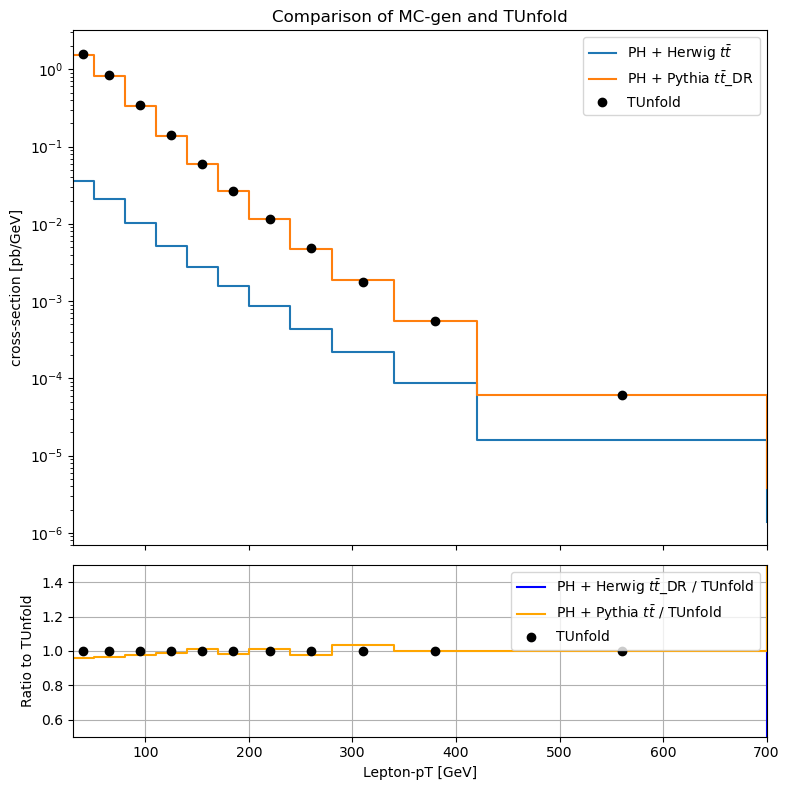

In [15]:
train_fraction_herwig = len(herwig_truth_train)/len(herwig_df)
train_fraction_pythia = len(pythia_truth_train)/len(pythia_df)
luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF_herwig = (1/luminosity)*1/train_fraction_herwig
SF_pythia = (1/luminosity)*1/train_fraction_pythia
hist = TUnfold_incl_file['unfolding_ptl1_NOSYS']
values = hist.values()
edges = hist.axis().edges()


fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    gridspec_kw={'height_ratios': [3, 1]}, 
    sharex=True
)

# --- Bin widths (same for all histograms) ---
bin_widths = np.diff(edges)

# --- Upper panel: your histograms ---
counts1, bins1, _ = ax1.hist(
    herwig_truth_train[:, 0, 0][herwig_loader.pass_gen], 
    weights=herwig_loader.weight[herwig_loader.pass_gen]*SF_herwig, 
    bins=edges, 
    histtype='step', 
    label='ttbar'
)

counts2, bins2, _ = ax1.hist(
    pythia_truth_train[:, 0, 0][pythia_loader.pass_gen], 
    weights=pythia_loader.weight[pythia_loader.pass_gen]*SF_pythia, 
    bins=edges, 
    histtype='step', 
    label='ttbar_DR'
)

# Normalize counts by bin width
counts1_density = counts1 / bin_widths
counts2_density = counts2 / bin_widths
values_density = values / bin_widths
bin_centers = 0.5 * (edges[:-1] + edges[1:])
# Re-plot them stepwise
ax1.cla()
ax1.step(edges[:-1], counts1_density, where="post", label=r"PH + Herwig $t\bar{t}$")
ax1.step(edges[:-1], counts2_density, where="post", label=r"PH + Pythia $t\bar{t}$_DR")
ax1.plot(bin_centers[:-1], values_density[:-1], 'o', color='black', label='TUnfold')

ax1.set_ylabel("cross-section [pb/GeV]")
ax1.set_title("Comparison of MC-gen and TUnfold")
ax1.legend()
ax1.set_yscale('log')

# --- Lower panel: ratio ---
# Avoid division by zero
ratio1 = np.divide(counts1_density, values_density, out=np.zeros_like(counts1_density), where=values_density!=0)
ratio2 = np.divide(counts2_density, values_density, out=np.zeros_like(counts2_density), where=values_density!=0)
ratio3 = np.ones_like(values_density)  # TUnfold / TUnfold

# Step style ratios
ratio1_step = np.append(ratio1, ratio1[-1])
ratio2_step = np.append(ratio2, ratio2[-1])

ax2.step(edges[:-1], ratio1_step[:-1], where="post", color="blue", label=r"PH + Herwig $t\bar{t}$_DR / TUnfold")
ax2.step(edges[:-1], ratio2_step[:-1], where="post", color="orange", label=r"PH + Pythia $t\bar{t}$ / TUnfold")
ax2.plot(bin_centers[:-1], ratio3[:-1], 'o', color='black', label='TUnfold')

#ax2.axhline(1.0, color='red', linestyle='--')

ax2.set_xlabel("Lepton-pT [GeV]")
ax2.set_ylabel("Ratio to TUnfold")
ax2.set_xlim(30,700)
ax2.set_ylim(0.5, 1.5)
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

In [16]:
ndim = 4 # 4 features: pt, eta, phi, mass
npart = 12 # 12 particles: l1, b1-4, j1-6, met

model1 = PET.PET(num_feat = 4, num_part = 12, local=False)
model2 = PET.PET(num_feat = 4, num_part = 12, local=False)

I0000 00:00:1762161979.656394 3651091 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 140842 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:c3:00.0, compute capability: 9.0


In [17]:
omnifold = test_omnifold.MultiFold(
    "closure_pythia_ttbarvsHerwig_singletop_linear",
    model1, # model_reco
    model2, # model_gen
    herwig_loader, # data
    pythia_loader, # MC
    batch_size = 128,
    niter = 3,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_singletop',
    verbose = True,
    early_stop=5,
    lr = 5e-6,
)

15625 training steps at reco and 15625 steps at gen


In [18]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 2000000, Test events used: 399999
################################################################################
Epoch 1/100


I0000 00:00:1762161990.377884 3656572 service.cc:152] XLA service 0x7fa3800095f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762161990.377931 3656572 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-11-03 10:26:30.549054: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762161991.448486 3656572 cuda_dnn.cc:529] Loaded cuDNN version 90501


   67/12500 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.5620 - loss: 0.0255   

I0000 00:00:1762161997.251710 3656572 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.5616 - loss: 0.0239 - val_accuracy: 0.5598 - val_loss: 0.0220 - learning_rate: 5.0000e-06
Epoch 2/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.5603 - loss: 0.0220 - val_accuracy: 0.5598 - val_loss: 0.0218 - learning_rate: 5.0000e-06
Epoch 3/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.5605 - loss: 0.0217 - val_accuracy: 0.5603 - val_loss: 0.0215 - learning_rate: 5.0000e-06
Epoch 4/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.5621 - loss: 0.0214 - val_accuracy: 0.5632 - val_loss: 0.0214 - learning_rate: 5.0000e-06
Epoch 5/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.5642 - loss: 0.0214 - val_accuracy: 0.5654 - val_loss: 0.0213 - learning_rate: 5.0000e-06
Epoch 6/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.5661 - loss: 0.0213 - val_accuracy: 0.5661 - val_loss: 0.0213 - learning_rate: 5.0000e-06
Epoch 7/100
12500/12500 ━━━━━━━━━━━━━━━━

In [19]:
unfolded_weights  = omnifold.reweight(Y_truth_scaled,omnifold.model2,batch_size=1000)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  


In [20]:
np.save("/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_singletop/unfolded_weights-linear.npy", unfolded_weights)

In [ ]:
#unfolded_weights = np.load("/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_singletop/unfolded_weights.npy")

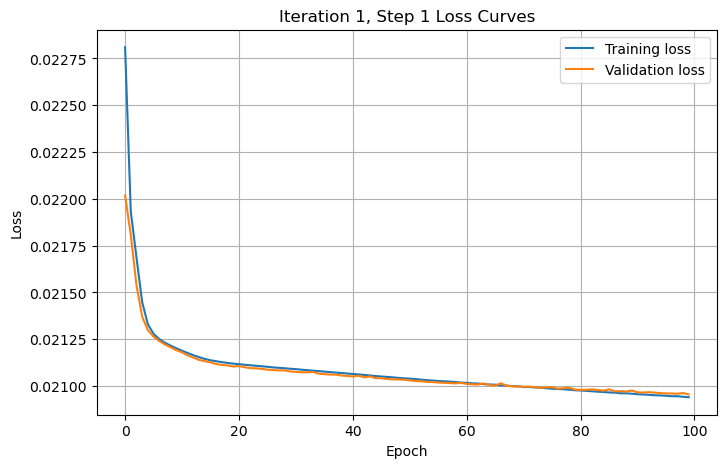

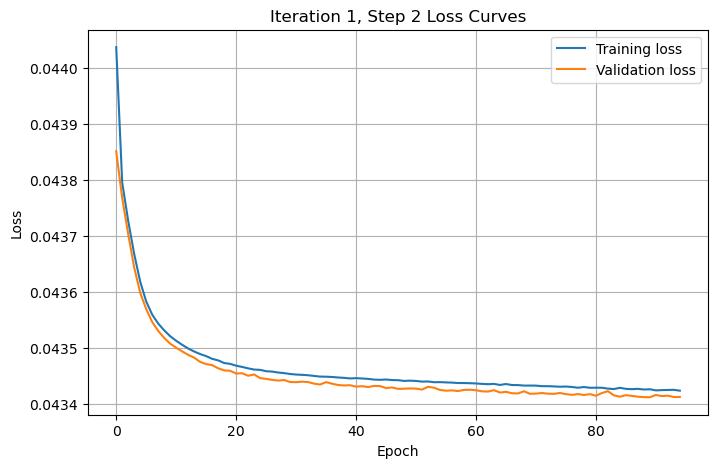

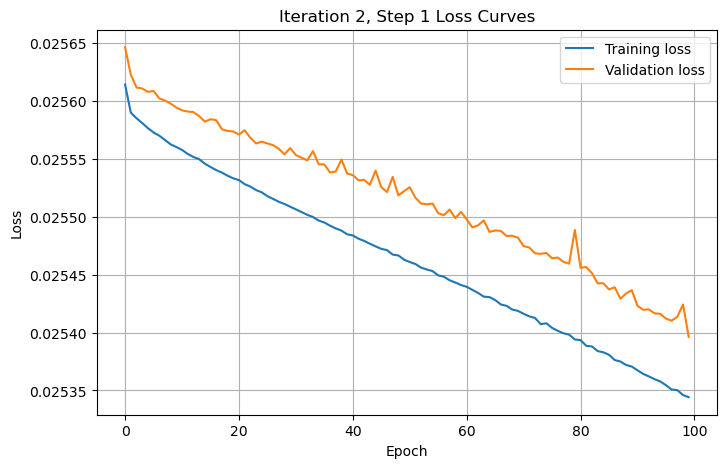

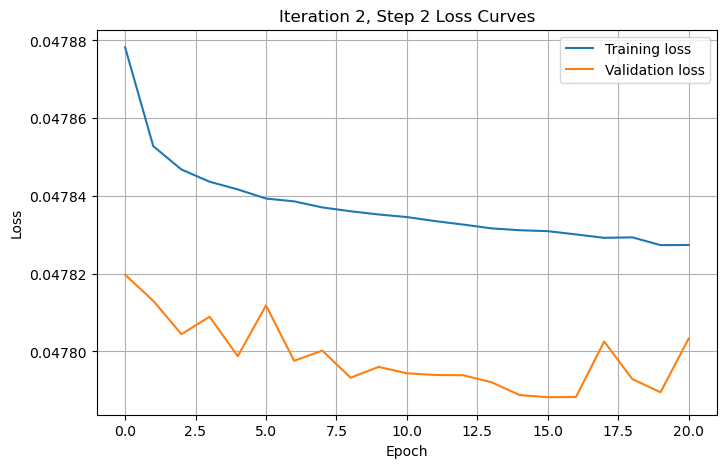

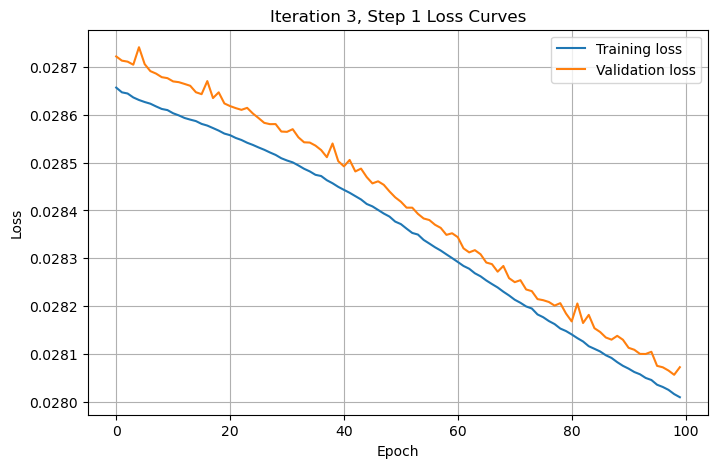

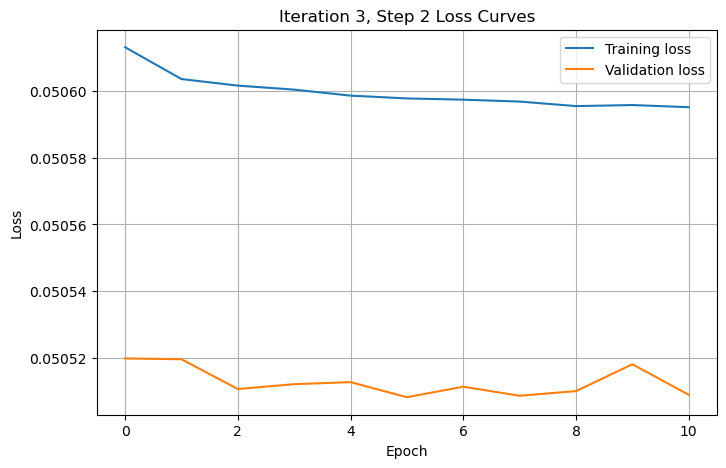

In [26]:
import pickle
import os
# Set these to your parameters
weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_singletop'      
name = "closure_pythia_ttbarvsHerwig_singletop_linear"    
niter = 3                       
n_ensemble = 1                  
# Loop over iterations and steps
for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            # Construct pickle file name
            model_file = f"{weights_folder}/OmniFold_{name}_iter{iteration}_step{stepn}"
            if n_ensemble > 1:
                model_file += f"_ensemble{e}"
            model_file += ".weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            # Load history
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
            else:
                print(f"History file not found: {history_file}")

        # Average over ensembles if multiple
        avg_loss = np.mean(all_loss, axis=0)
        avg_val_loss = np.mean(all_val_loss, axis=0)

        plt.plot(avg_loss, label='Training loss')
        plt.plot(avg_val_loss, label='Validation loss')
        plt.legend()
        plt.grid(True)
        plt.show()


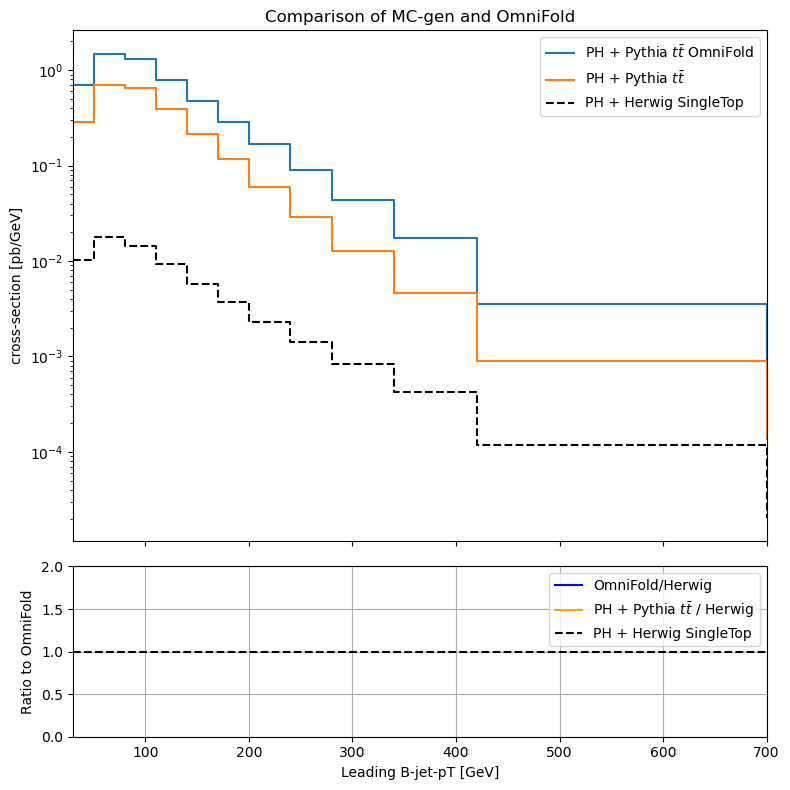

In [34]:
test_fraction_herwig = len(herwig_truth_test)/len(herwig_df)
test_fraction_pythia = len(pythia_truth_test)/len(pythia_df)
luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF_herwig_test = (1/luminosity)*1/test_fraction_herwig
SF_pythia_test = (1/luminosity)*1/test_fraction_pythia

hist = TUnfold_incl_file['unfolding_ptl1_NOSYS']
values = hist.values()
edges = hist.axis().edges()


fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    gridspec_kw={'height_ratios': [3, 1]}, 
    sharex=True
)

# --- Bin widths (same for all histograms) ---
bin_widths = np.diff(edges)

# --- Upper panel: your histograms ---

counts1, bins1, _ = ax1.hist(
    pythia_truth_test[:, 1, 0][testset_loader.pass_gen], 
    weights=(pythia_weights_test*unfolded_weights)[testset_loader.pass_gen]*SF_pythia_test, 
    bins=edges, 
    histtype='step', 
    label='Pythia ttbar OmniFold'
)

counts2, bins2, _ = ax1.hist(
    pythia_truth_test[:, 1, 0][testset_loader.pass_gen], 
    weights=pythia_weights_test[testset_loader.pass_gen]*SF_pythia_test, 
    bins=edges, 
    histtype='step', 
    label='Pythia ttbar'
)

counts3, bins3, _ = ax1.hist(
    herwig_truth_train[:, 1, 0][herwig_loader.pass_gen], 
    weights=herwig_weights_train[herwig_loader.pass_gen]*SF_herwig, 
    bins=edges, 
    histtype='step', 
    label='Herwig ttbar+singletop'
)

# Normalize counts by bin width
counts1_density = counts1 / bin_widths
counts2_density = counts2 / bin_widths
counts3_density = counts3 / bin_widths
# Re-plot them stepwise
ax1.cla()
ax1.step(edges[:-1], counts1_density, where="post", label=r"PH + Pythia $t\bar{t}$ OmniFold")
ax1.step(edges[:-1], counts2_density, where="post", label=r"PH + Pythia $t\bar{t}$")
ax1.step(edges[:-1], counts3_density, where="post", color='black', label=r"PH + Herwig SingleTop", ls='--')


ax1.set_ylabel("cross-section [pb/GeV]")
ax1.set_title("Comparison of MC-gen and OmniFold")
ax1.legend()
ax1.set_yscale('log')

# --- Lower panel: ratio ---
# Avoid division by zero
ratio1 = np.divide(counts1_density, counts3_density, out=np.zeros_like(counts1_density), where=counts3_density!=0)
ratio2 = np.divide(counts2_density, counts3_density, out=np.zeros_like(counts2_density), where=counts3_density!=0)
ratio3 = np.ones_like(counts3_density)  # Herwig/Herwig

# Step style ratios
ratio1_step = np.append(ratio1, ratio1[-1])
ratio2_step = np.append(ratio2, ratio2[-1])

ax2.step(edges[:-1], ratio1_step[:-1], where="post", color="blue", label="OmniFold/Herwig")
ax2.step(edges[:-1], ratio2_step[:-1], where="post", color="orange", label=r"PH + Pythia $t\bar{t}$ / Herwig")
ax2.step(edges[:-1], ratio3, where="post", color='black', label=r"PH + Herwig SingleTop", ls='--')


ax2.set_xlabel("Leading B-jet-pT [GeV]")
ax2.set_ylabel("Ratio to OmniFold")
ax2.set_xlim(30,700)
ax2.set_ylim(0, 2)
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

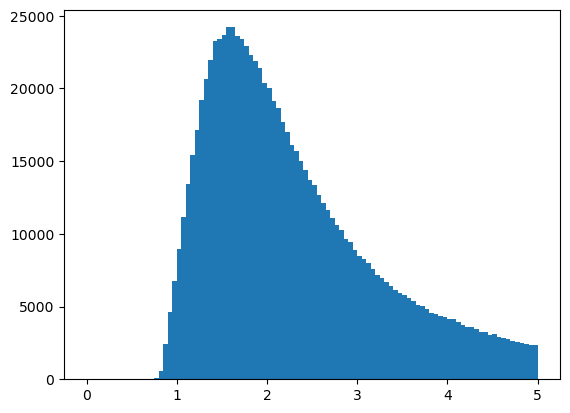

In [41]:
plt.hist(unfolded_weights, bins=100, range=[0,5])

plt.show()

/scratch/mjosef/Unfolding/omnifold/omnifold/utils.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(9, 9))


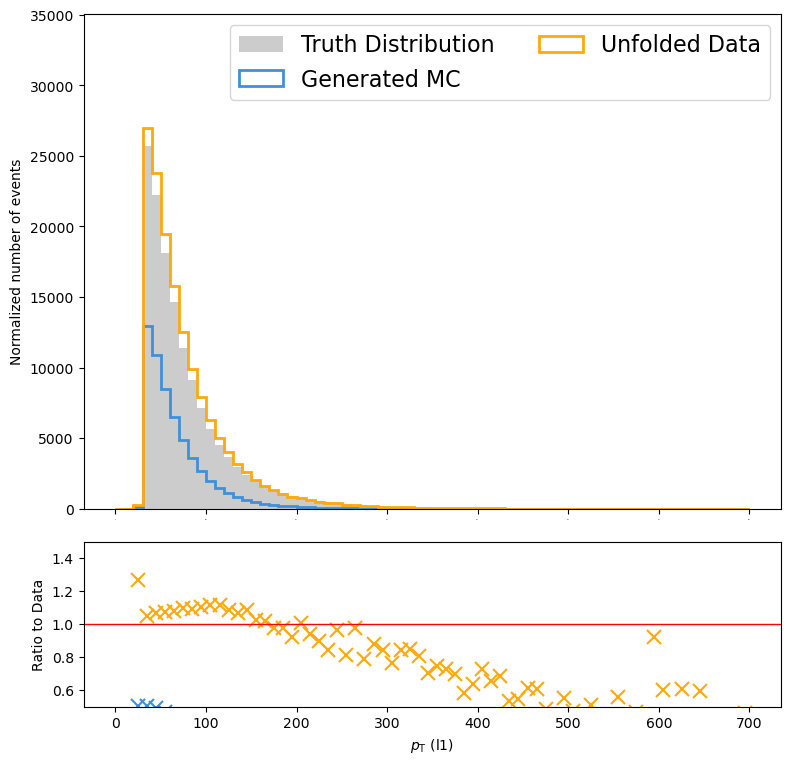

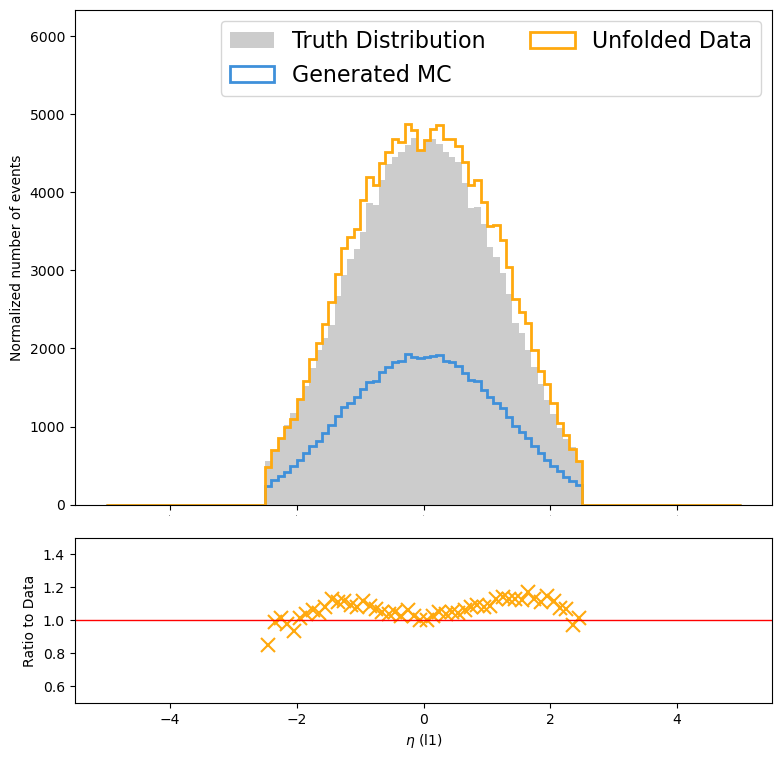

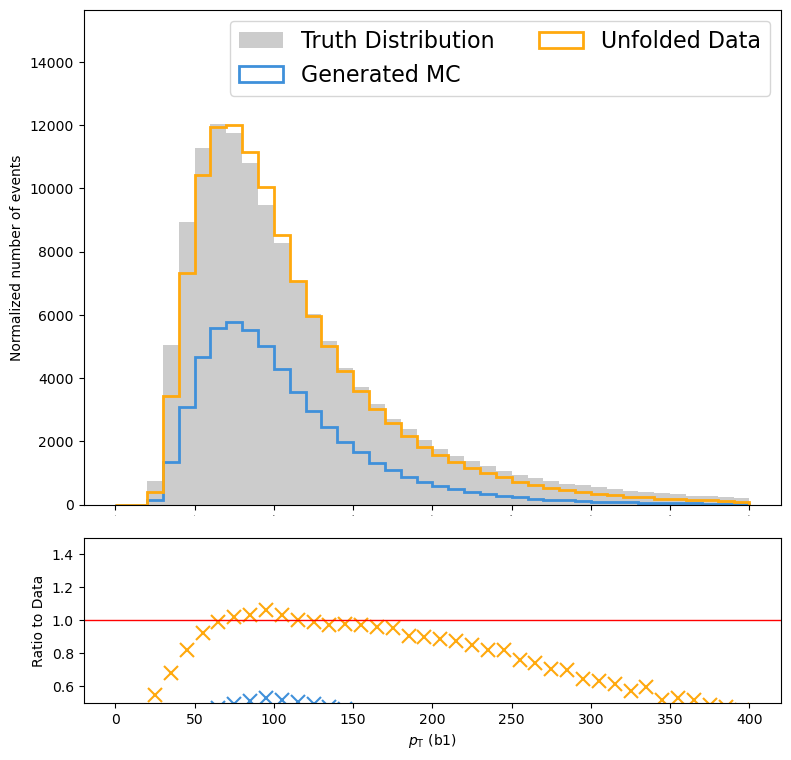

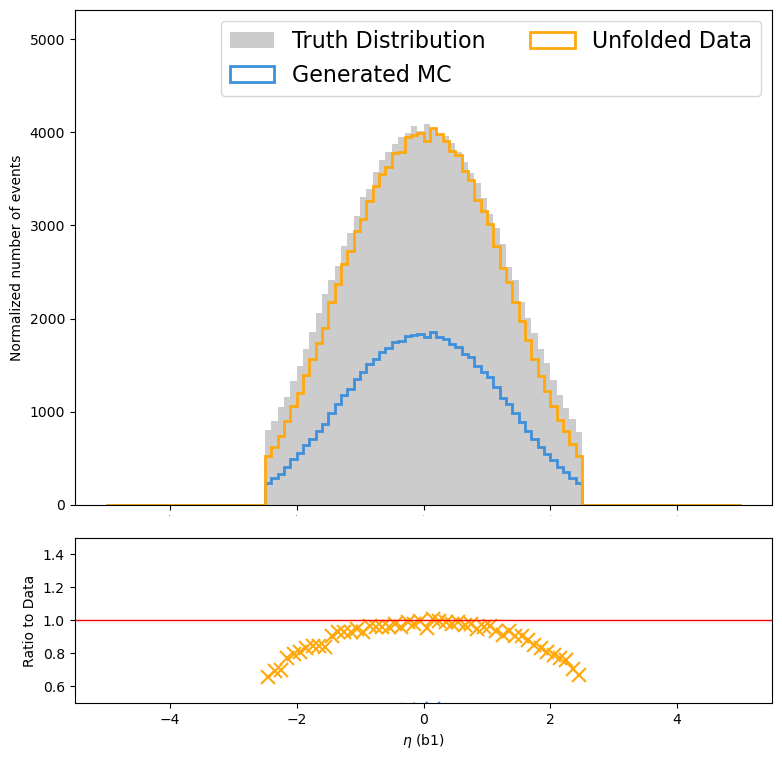

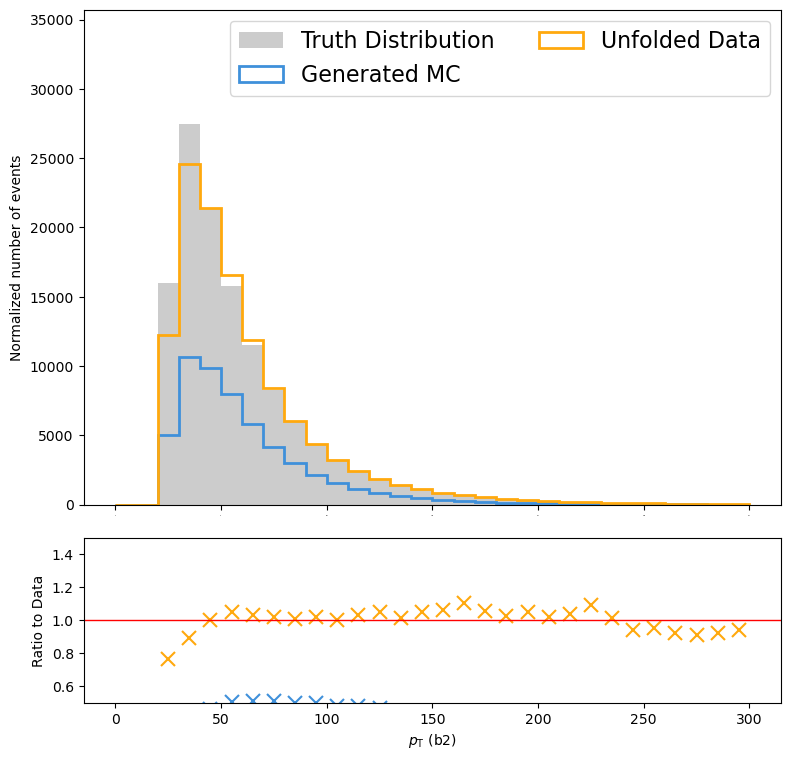

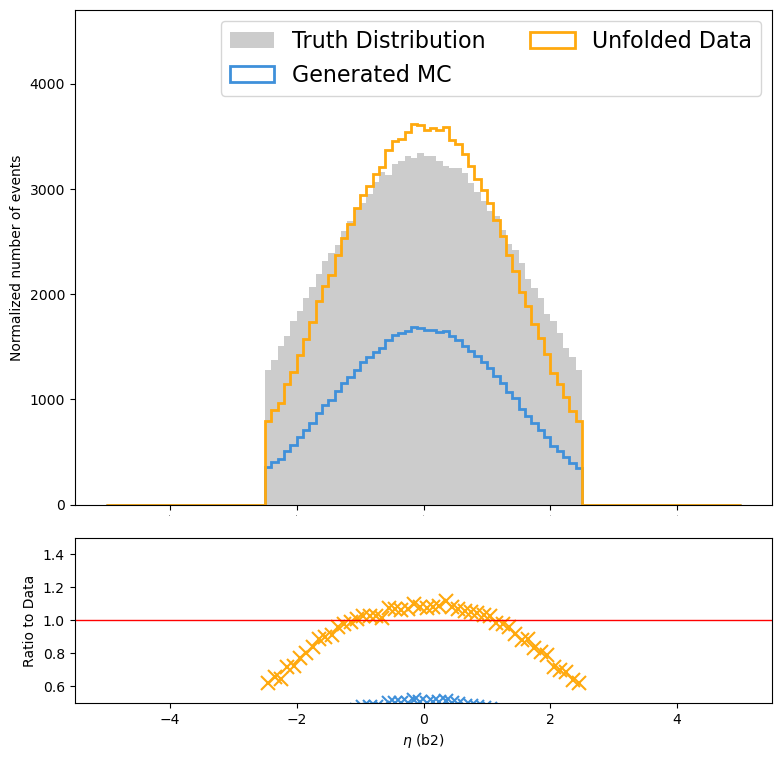

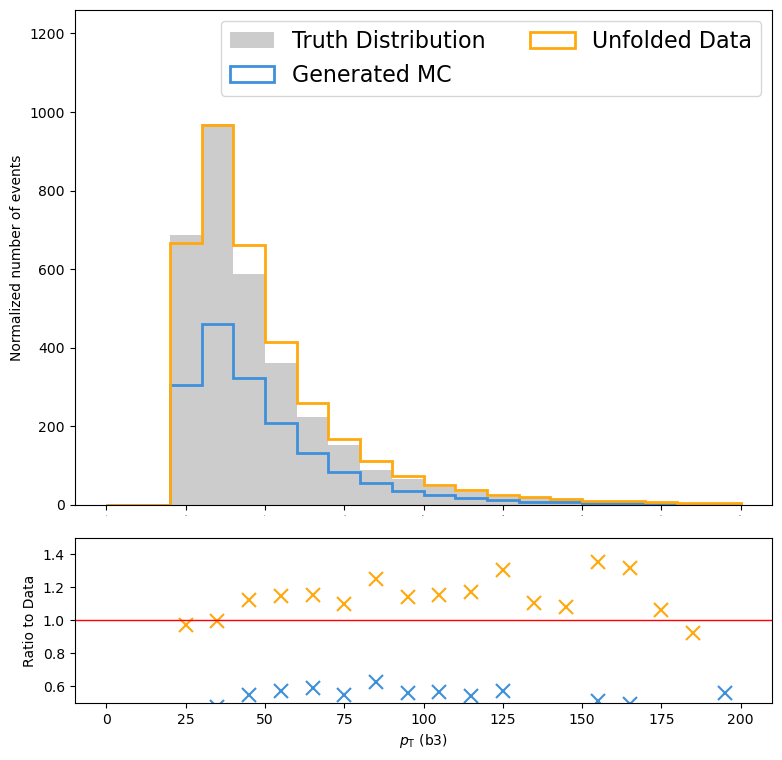

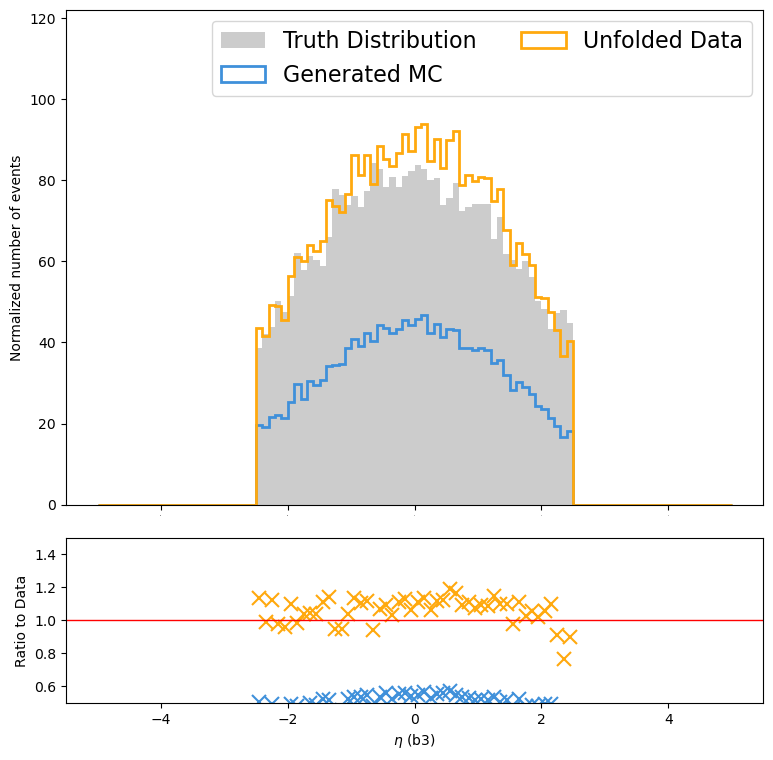

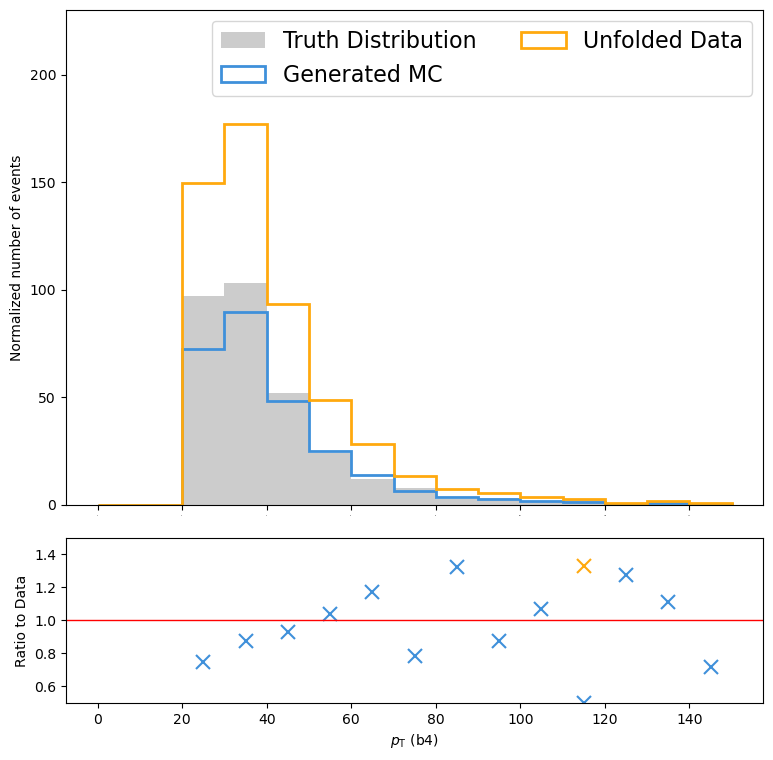

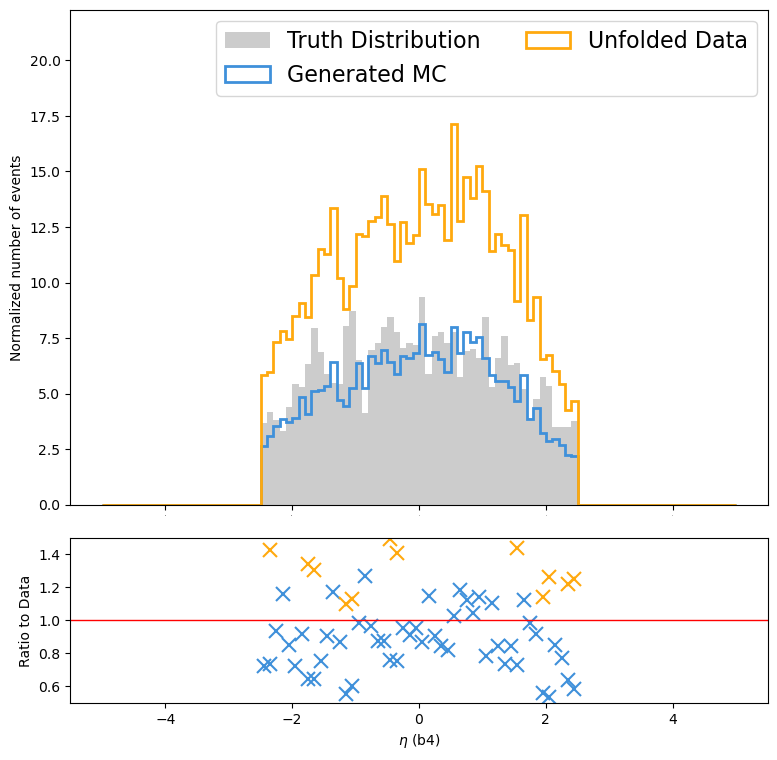

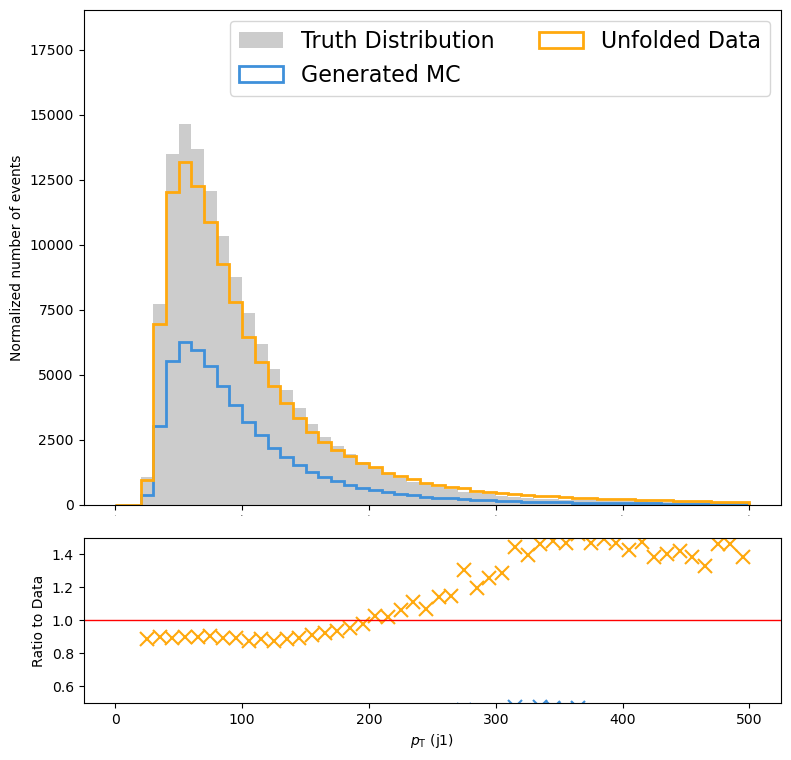

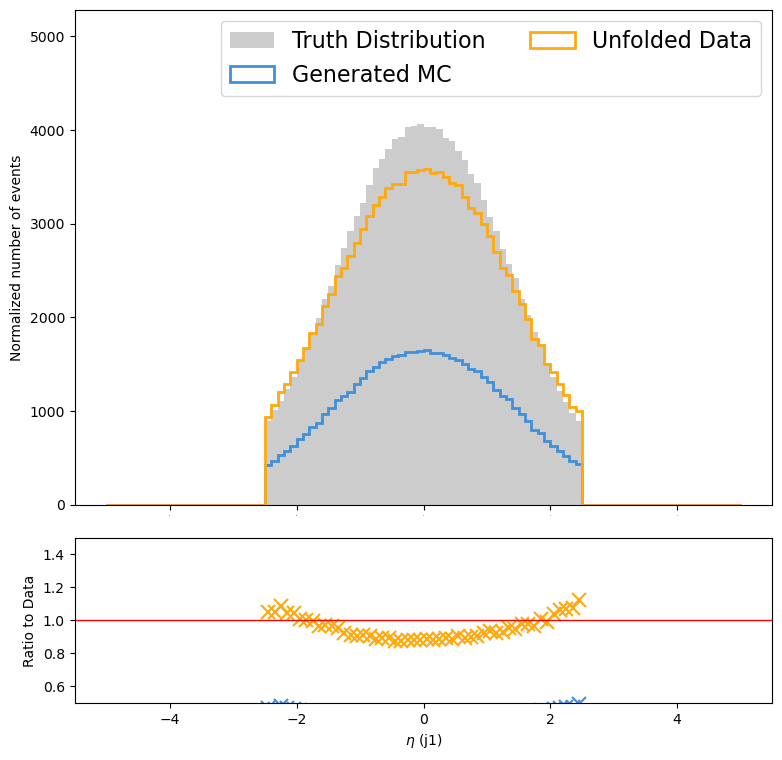

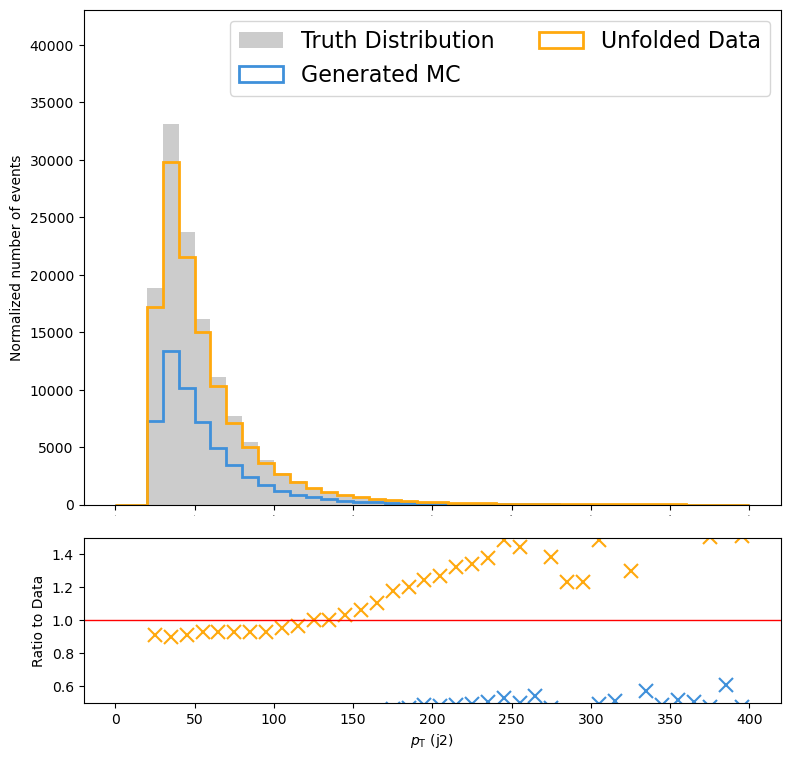

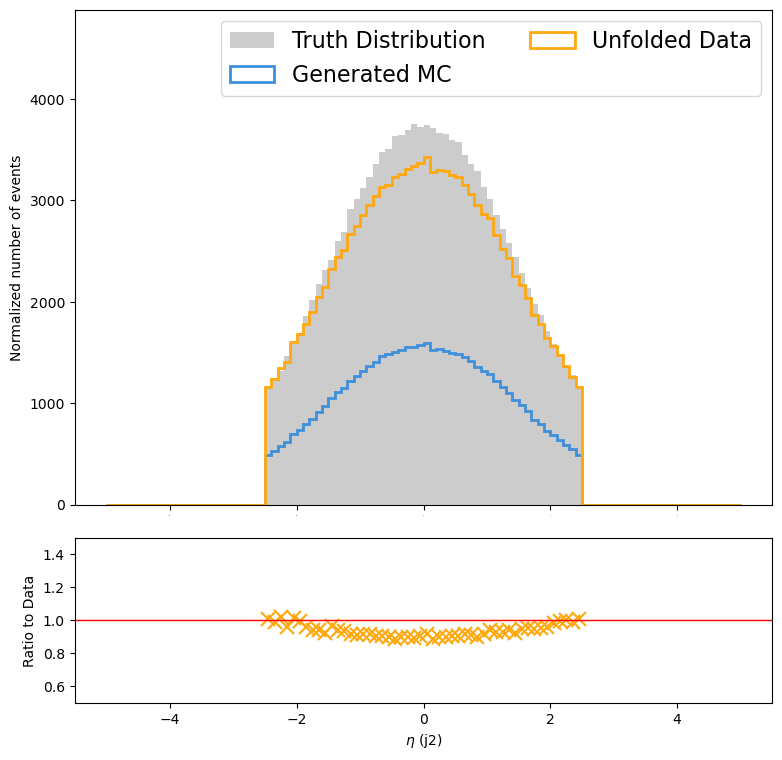

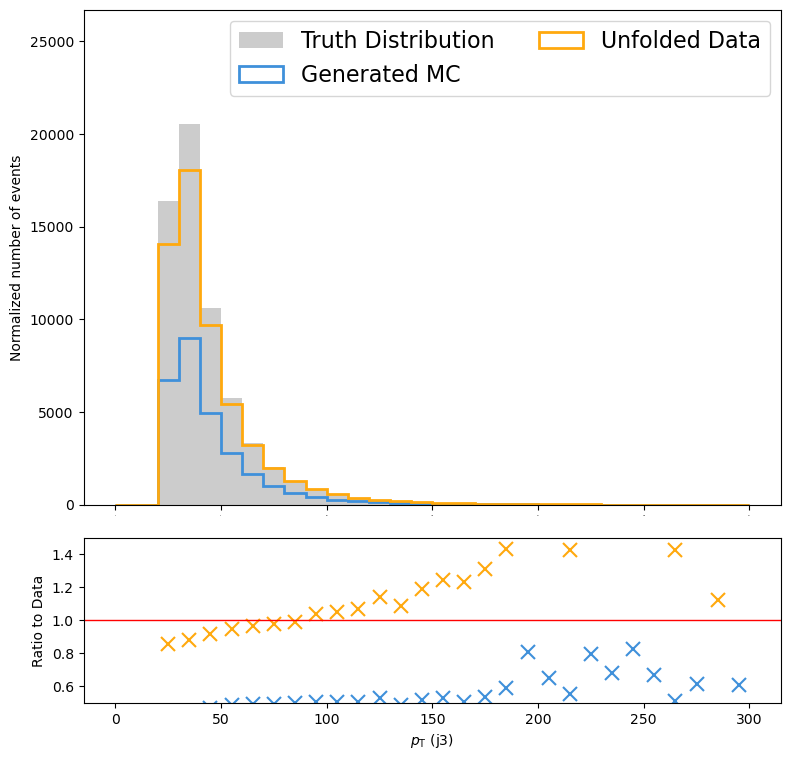

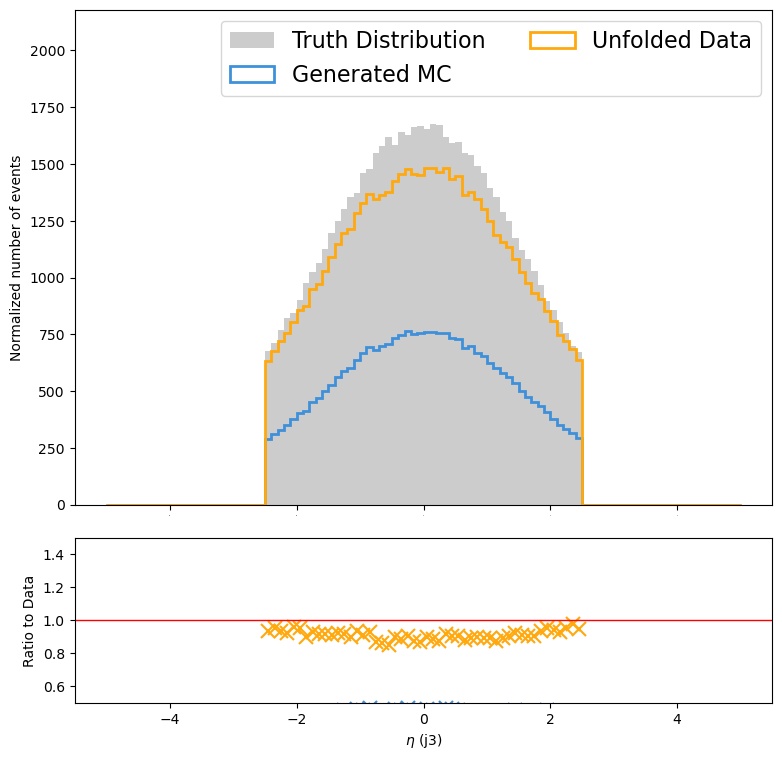

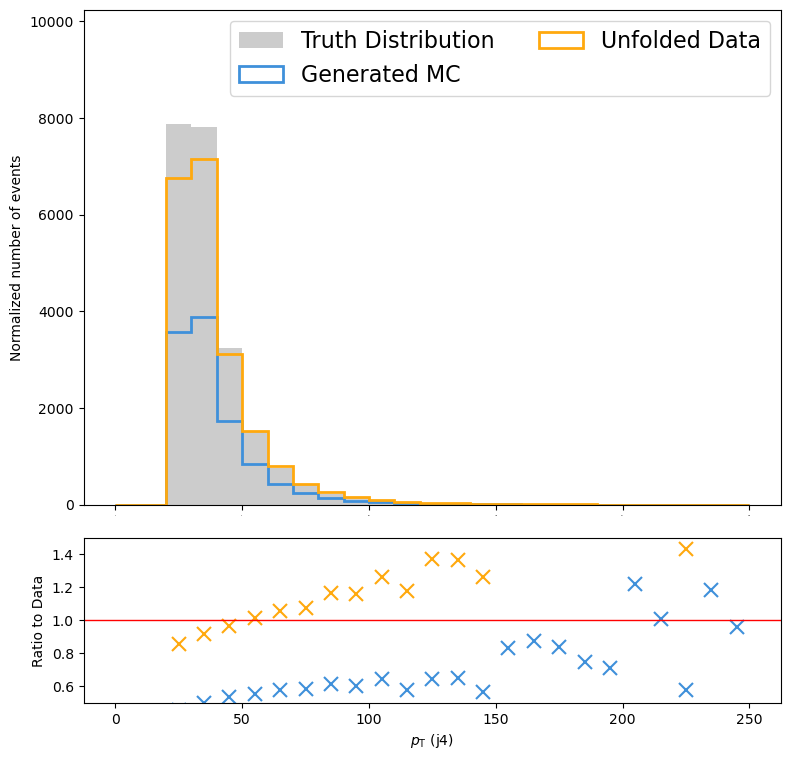

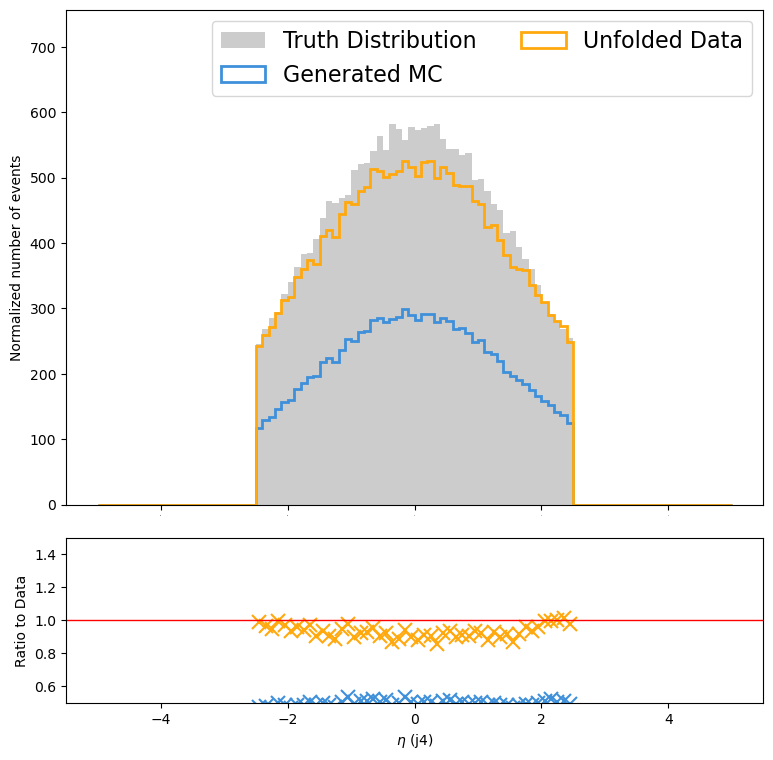

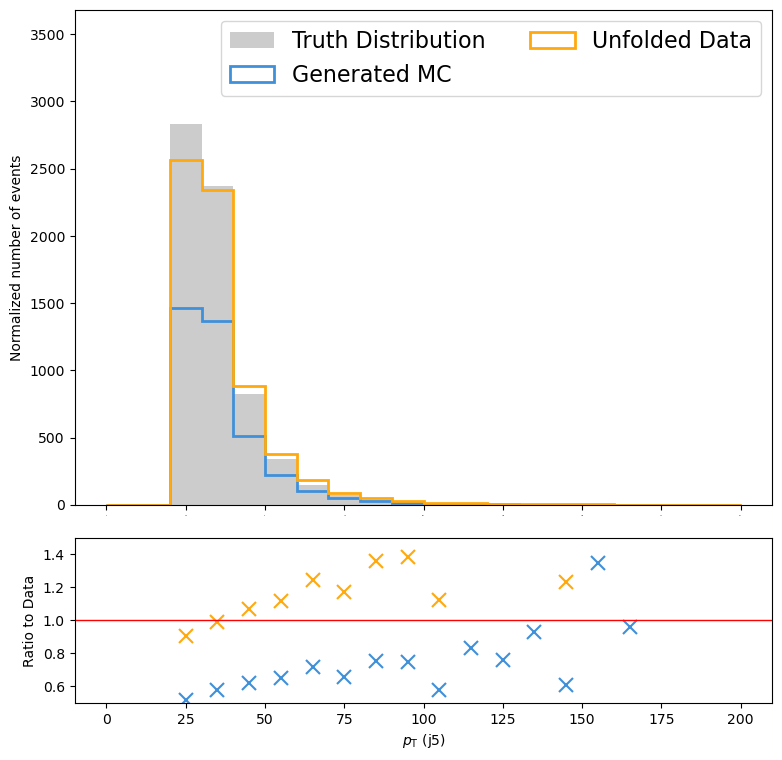

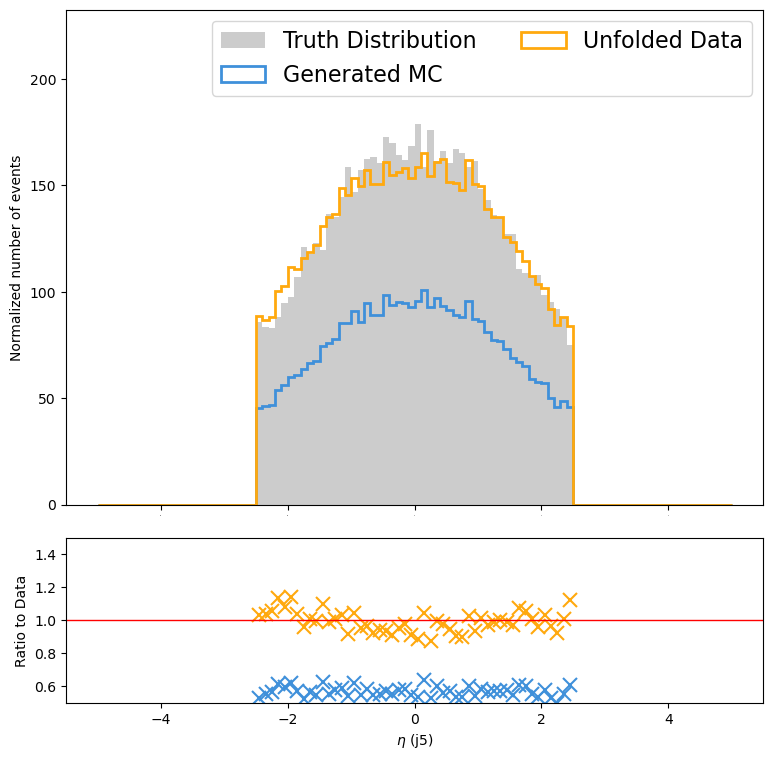

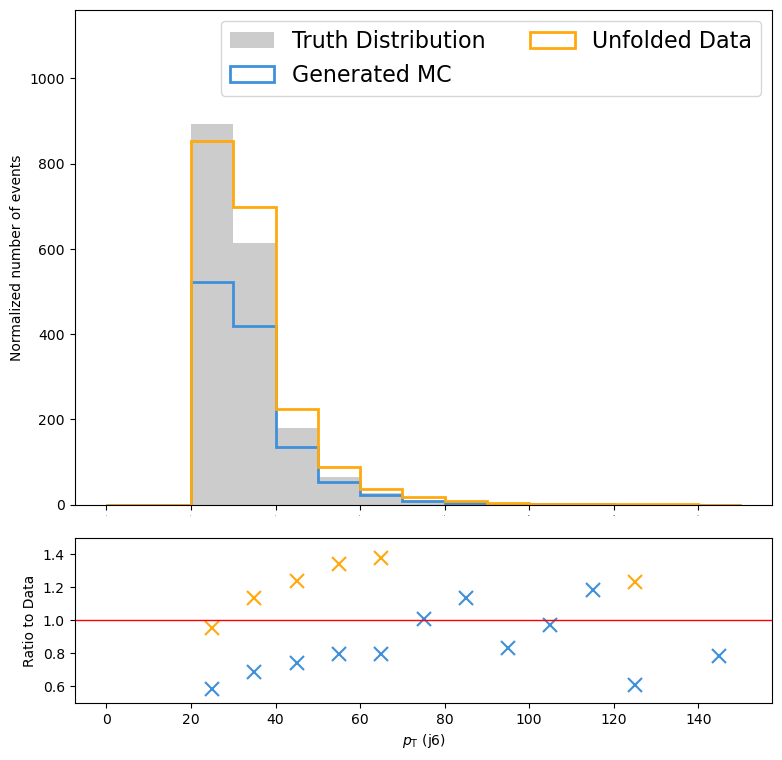

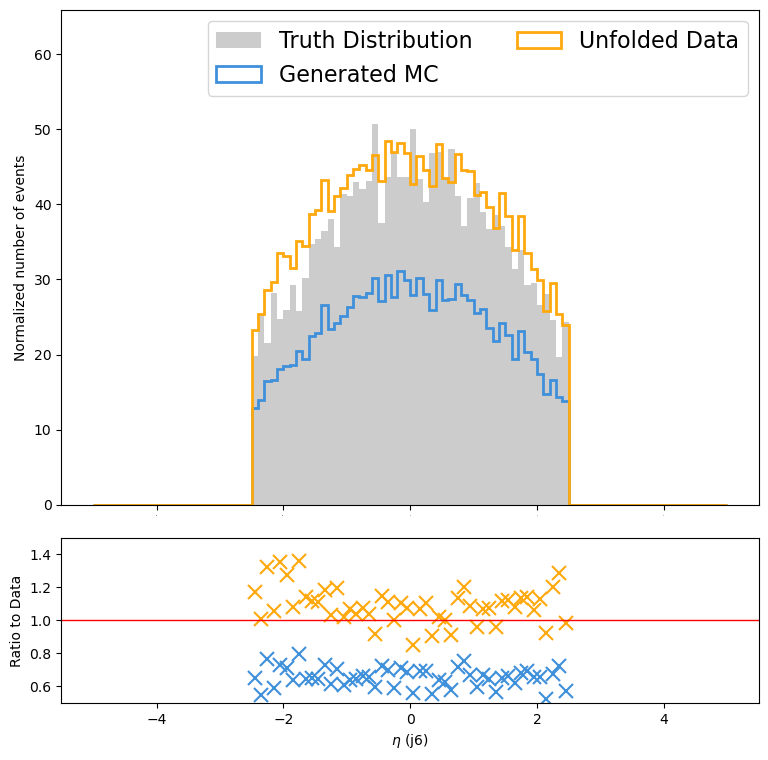

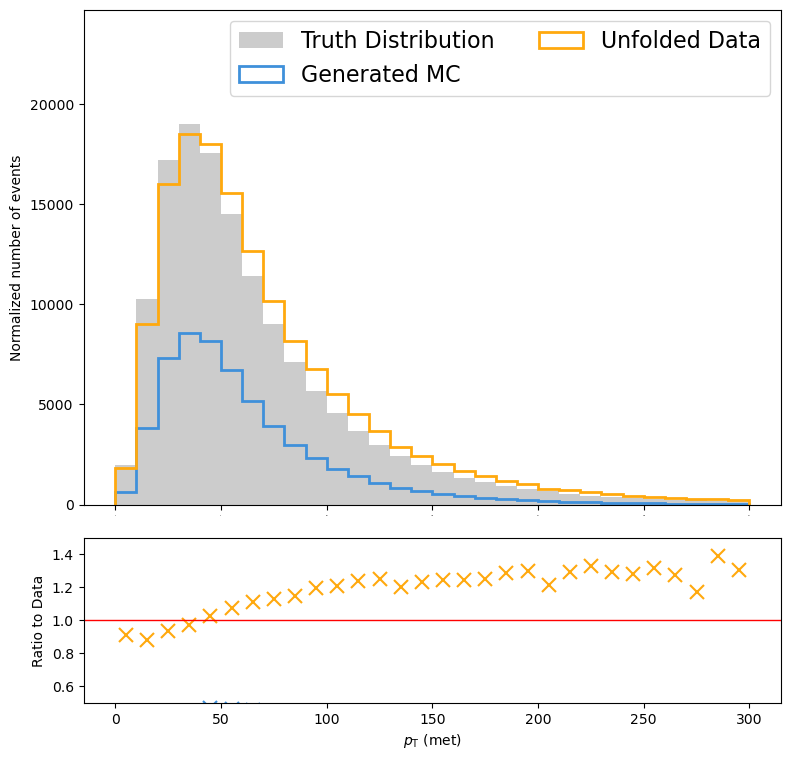

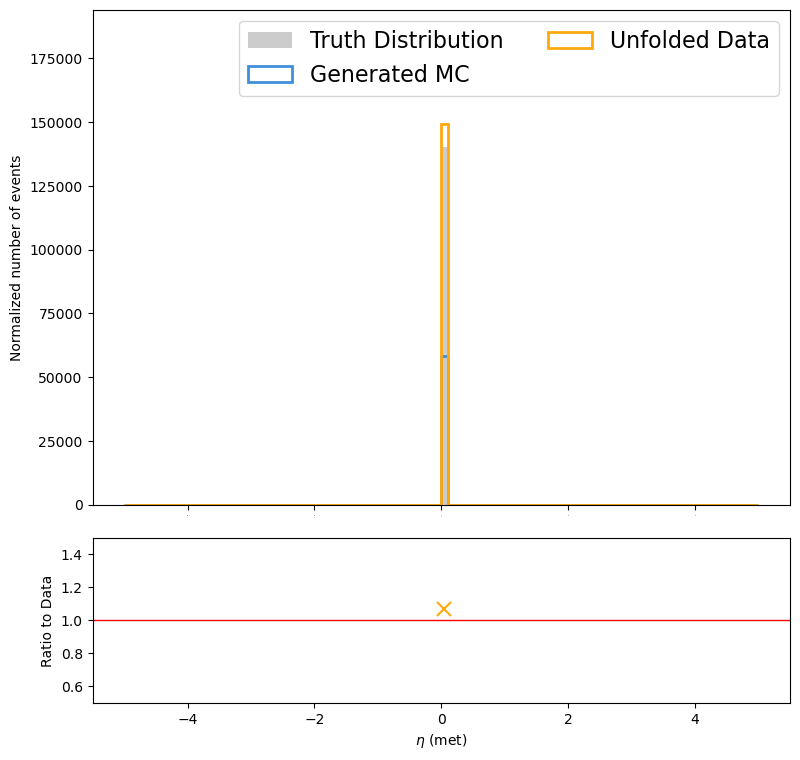

In [42]:
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

pt_binning = {
    'l1': np.linspace(0, 700, 71),
    'b1': np.linspace(0, 400, 41),
    'b2': np.linspace(0, 300, 31),
    'b3': np.linspace(0, 200, 21),
    'b4': np.linspace(0, 150, 16),
    'j1': np.linspace(0, 500, 51),
    'j2': np.linspace(0, 400, 41),
    'j3': np.linspace(0, 300, 31),
    'j4': np.linspace(0, 250, 26),
    'j5': np.linspace(0, 200, 21),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}
default_binning = [
    None,  # placeholder for pt, unused
    np.linspace(-5, 5, 101),     # eta
]

labels = [
    r"$p_\mathrm{T}$",
    r"$\eta$",
]


for i, pname in enumerate(particles):
    for obs_index in range(2):  # 0: pT, 1: eta
        if obs_index == 0:
            bins = pt_binning[pname]
        else:
            bins = default_binning[obs_index]
        data_dict = {
            'Truth Distribution': herwig_truth_train[:, i, obs_index][herwig_truth_train[:, i, 0]!=0],
            #'Reconstructed Data': herwig_loader.reco[:, i, obs_index][herwig_loader.reco[:, i, 0]!=0],
            'Generated MC': pythia_truth_test[:, i, obs_index][pythia_truth_test[:, i, 0]!=0],
            #'Reconstructed MC': pythia_loader.reco[:, i, obs_index][(pythia_loader.reco[:, i, 0]!=0)],
            'Unfolded Data': pythia_truth_test[:, i, obs_index][pythia_truth_test[:, i, 0]!=0],
        }

        weight_dict = {
            'Truth Distribution': herwig_weights_train[herwig_truth_train[:, i, 0]!=0],
            #'Reconstructed Data': herwig_loader.weight[herwig_loader.reco[:, i, 0]!=0],
            'Generated MC': pythia_weights_test[(pythia_truth_test[:, i, 0]!=0)],
            #'Reconstructed MC': pythia_loader.weight[(pythia_loader.reco[:, i, 0]!=0)],
            'Unfolded Data': (unfolded_weights*pythia_weights_test)[pythia_truth_test[:, i, 0]!=0],
        }

        fig, _ = HistRoutine(
            data_dict,
            f"{labels[obs_index]} ({pname})",
            reference_name='Truth Distribution',
            weights=weight_dict,
            plot_ratio=True,
            binning=bins,
        )

In [43]:
def convert_to4vector(array):
    """
    Convert an array of shape (n_events, n_particles, 4) with (pt, eta, phi, m)
    to an array of shape (n_events, n_particles, 4) with (E, px, py, pz).
    """
    pt = array[:, 0]
    eta = array[:, 1]
    phi = array[:, 2]
    m = array[:, 3]

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = np.sqrt(px**2 + py**2 + pz**2 + m**2)

    return np.stack((E, px, py, pz), axis=-1)

def calculate_mass(array):
    """
    Calculate the invariant mass of the system represented by the input array.
    The input array should have shape (n_events, n_particles, 4) with (E, px, py, pz).
    Returns an array of shape (n_events,) with the invariant mass for each event.
    """
    E = array[:, 0]
    px = array[:, 1]
    py = array[:, 2]
    pz = array[:, 3]

    mass_squared = E**2 - (px**2 + py**2 + pz**2)
    mass_squared = np.maximum(mass_squared, 0)  # Avoid negative values due to numerical issues
    return np.sqrt(mass_squared)

def W_candidate(array):
    # Hard coded W mass
    W_mass = 80.379

    # leading and subleading jets (indices 5 and 6)
    leading_jet = array[:, 5, :]
    subleading_jet = array[:, 6, :]
    leading_jet_4vec = convert_to4vector(leading_jet)
    subleading_jet_4vec = convert_to4vector(subleading_jet)
    combined_4vec = leading_jet_4vec + subleading_jet_4vec

    # Calculate masses
    mass_leading = calculate_mass(leading_jet_4vec)
    mass_subleading = calculate_mass(subleading_jet_4vec)
    mass_combined = calculate_mass(combined_4vec)

    # Stack all masses and 4-vectors: shape (n_events, 3)
    all_masses = np.stack([mass_leading, mass_subleading, mass_combined], axis=1)
    all_4vecs = np.stack([leading_jet_4vec, subleading_jet_4vec, combined_4vec], axis=1)

    # Find index of mass closest to W_mass for each event
    idx_closest = np.argmin(np.abs(all_masses - W_mass), axis=1)

    # Select 4-vector for each event
    selected_4vec = all_4vecs[np.arange(len(array)), idx_closest, :]

    return selected_4vec

def min_mbl(array):
    # b-jet indices: 1, 2
    b_jets = [array[:, i, :] for i in range(1,3)]
    lepton = array[:, 0, :]

    b_jet_4vecs = [convert_to4vector(b_jet) for b_jet in b_jets]
    lepton_4vec = convert_to4vector(lepton)

    mbl_values = []
    for b_jet_4vec in b_jet_4vecs:
        combined_4vec = b_jet_4vec + lepton_4vec
        mbl = calculate_mass(combined_4vec)
        mbl_values.append(mbl)

    mbl_stack = np.stack(mbl_values, axis=1)  # shape (n_events, 2)
    return np.min(mbl_stack, axis=1)  # shape (n_events,)

def min_mbW(array):
    # b-jet indices: 1, 2
    b_jet1 = array[:, 1, :]
    b_jet2 = array[:, 2, :]

    b_jet1_4vec = convert_to4vector(b_jet1)
    b_jet2_4vec = convert_to4vector(b_jet2)

    W_4vec = W_candidate(array)

    combined1_4vec = b_jet1_4vec + W_4vec
    combined2_4vec = b_jet2_4vec + W_4vec

    mbW1 = calculate_mass(combined1_4vec)
    mbW2 = calculate_mass(combined2_4vec)

    mbW_stack = np.stack([mbW1, mbW2], axis=1)  # shape (n_events, 2)
    return np.min(mbW_stack, axis=1)  # shape (n_events,)


def mbb(array):
    # b-jet indices: 1, 2
    b_jet1 = array[:, 1, :]
    b_jet2 = array[:, 2, :]

    b_jet1_4vec = convert_to4vector(b_jet1)
    b_jet2_4vec = convert_to4vector(b_jet2)

    combined_4vec = b_jet1_4vec + b_jet2_4vec
    return calculate_mass(combined_4vec)

def dR2b(array):
    # b-jet indices: 1, 2
    b_jet1 = array[:, 1, :]
    b_jet2 = array[:, 2, :]

    eta1 = b_jet1[:, 1]
    phi1 = b_jet1[:, 2]
    eta2 = b_jet2[:, 1]
    phi2 = b_jet2[:, 2]

    delta_eta = eta1 - eta2
    delta_phi = np.abs(phi1 - phi2)
    delta_phi = np.where(delta_phi > np.pi, 2 * np.pi - delta_phi, delta_phi)

    return np.sqrt(delta_eta**2 + delta_phi**2)

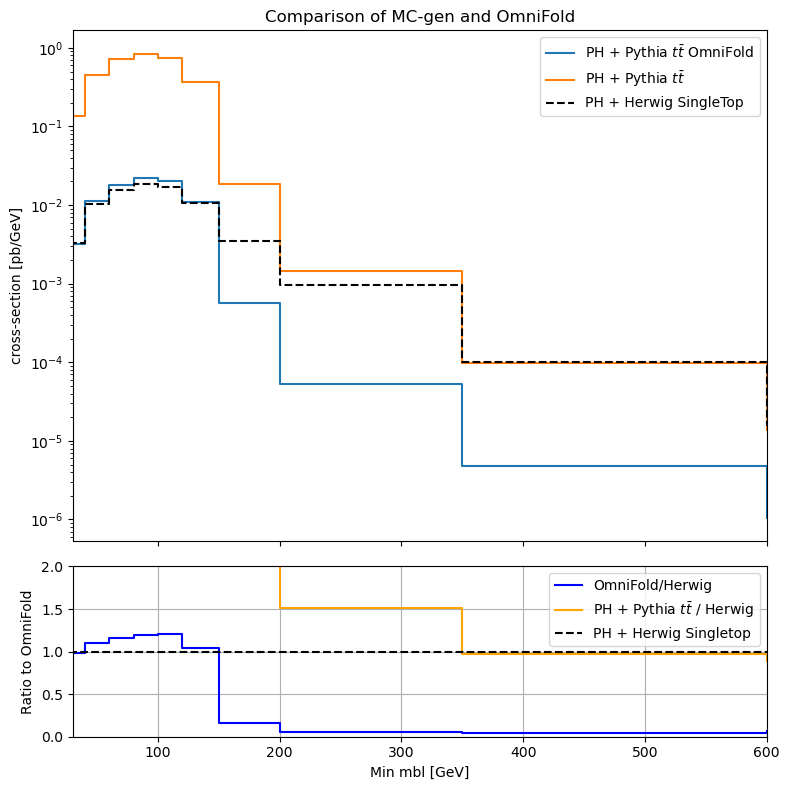

In [45]:
test_fraction_herwig = len(herwig_truth_test)/len(herwig_df)
test_fraction_pythia = len(pythia_truth_test)/len(pythia_df)
luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF_herwig_test = (1/luminosity)*1/test_fraction_herwig
SF_pythia_test = (1/luminosity)*1/test_fraction_pythia

hist = TUnfold_incl_file['unfolding_mblmin_NOSYS']
values = hist.values()
edges = hist.axis().edges()


fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    gridspec_kw={'height_ratios': [3, 1]}, 
    sharex=True
)

# --- Bin widths (same for all histograms) ---
bin_widths = np.diff(edges)

# --- Upper panel: your histograms ---

counts1, bins1, _ = ax1.hist(
    min_mbl(pythia_truth_test)[testset_loader.pass_gen], 
    weights=(pythia_weights_test*unfolded_weights)[testset_loader.pass_gen]*SF_herwig, 
    bins=edges, 
    histtype='step', 
    label='Pythia ttbar OmniFold'
)

counts2, bins2, _ = ax1.hist(
    min_mbl(pythia_truth_test)[testset_loader.pass_gen], 
    weights=pythia_weights_test[testset_loader.pass_gen]*SF_pythia_test, 
    bins=edges, 
    histtype='step', 
    label='Pythia ttbar'
)

counts3, bins3, _ = ax1.hist(
    min_mbl(herwig_truth_train)[herwig_loader.pass_gen], 
    weights=herwig_weights_train[herwig_loader.pass_gen]*SF_herwig, 
    bins=edges, 
    histtype='step', 
    label='Herwig ttbar+singletop'
)

# Normalize counts by bin width
counts1_density = counts1 / bin_widths
counts2_density = counts2 / bin_widths
counts3_density = counts3 / bin_widths
# Re-plot them stepwise
ax1.cla()
ax1.step(edges[:-1], counts1_density, where="post", label=r"PH + Pythia $t\bar{t}$ OmniFold")
ax1.step(edges[:-1], counts2_density, where="post", label=r"PH + Pythia $t\bar{t}$")
ax1.step(edges[:-1], counts3_density, where="post", color='black', label=r"PH + Herwig SingleTop", ls='--')


ax1.set_ylabel("cross-section [pb/GeV]")
ax1.set_title("Comparison of MC-gen and OmniFold")
ax1.legend()
ax1.set_yscale('log')

# --- Lower panel: ratio ---
# Avoid division by zero
ratio1 = np.divide(counts1_density, counts3_density, out=np.zeros_like(counts1_density), where=counts3_density!=0)
ratio2 = np.divide(counts2_density, counts3_density, out=np.zeros_like(counts2_density), where=counts3_density!=0)
ratio3 = np.ones_like(counts3_density)  # Herwig/Herwig

# Step style ratios
ratio1_step = np.append(ratio1, ratio1[-1])
ratio2_step = np.append(ratio2, ratio2[-1])

ax2.step(edges[:-1], ratio1_step[:-1], where="post", color="blue", label="OmniFold/Herwig")
ax2.step(edges[:-1], ratio2_step[:-1], where="post", color="orange", label=r"PH + Pythia $t\bar{t}$ / Herwig")
ax2.step(edges[:-1], ratio3, where="post", color='black', label=r"PH + Herwig Singletop", ls='--')


ax2.set_xlabel("Min mbl [GeV]")
ax2.set_ylabel("Ratio to OmniFold")
ax2.set_xlim(30,600)
ax2.set_ylim(0, 2)
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()